# Computing dark photon cross sections

Please be aware of the fact that you will create a file each time you run this macro 

## What's in there

This small program is supposed to compute the cross section of Dark mediator production in function of its mass.

## Prerequisite

This notebook asks you to have Ipython and plotly to enjoy it to the fullest, if not can still be enjoyed though.

## Articles & other sources of informations used

* https://arxiv.org/abs/1209.6083 New Limits on Hidden Photons from Past Electron Beam Dumps, Not really used it but might be interesting nonetheless
* https://arxiv.org/abs/0906.0580 New Fixed-Target Experiments to Search for Dark Gauge Forces Appendix A and in particular
    * Definition of $\beta_{A'}$ (annotated only by $\beta$ by me) (Right after equation A12)
    * The definition of $\chi$ (A17)
    * Use especially eq A17, A18, A19
    * parameters $a$, $d$, $a'$, $\mu_p$
    * Fig 10 ($\frac{\chi}{Z^2}$) was used as cross check (the code can be quickly adapted to plot those quantities too if you so desire)
* https://arxiv.org/abs/1411.1404 Testing GeV-Scale Dark Matter with Fixed-Target Missing Momentum Experiments
    * approximation of the cross section which is eq 8
    * $\delta$ is defined in equation 7 
    * Fig 5 is the one that I use as a reference 

Furthermore the radiation lengths, in g/cm$^2$, can be found at the following link http://pdg.lbl.gov/2011/AtomicNuclearProperties/

more precisely Tungsten here http://pdg.lbl.gov/2011/AtomicNuclearProperties/HTML_PAGES/074.html

Aluminium there http://pdg.lbl.gov/2011/AtomicNuclearProperties/HTML_PAGES/013.html

## formulas used explicitely
\begin{align*}
\sigma_{A'} &\approx F\ \frac{4}{3}\ \frac{\alpha^3\epsilon^2}{{m^2_{A'}}}\ \sqrt{1-{\left(\frac{m_{A'}}{E_0}\right)}^2}\chi_{(Z,m_{A'},E_0)}\left[\ln(\delta^{-1})+O(1)\right]\\[1em]
\delta &\equiv \max\left(\frac{m_{A'}}{E_0},\frac{m^2_e}{m^2_{A'}},\frac{m_e}{E_0} \right )\\[1em]
\chi &\equiv \int_{t_m}^{t_M}\left(\frac{t-t_m}{t^2}\right) \left(G_{2,in(t)} + G_{2,el(t)}\right){dt}\\[1em]
\chi_{el} &\equiv \int_{t_m}^{t_M}\left(\frac{t-t_m}{t^2}\right) \left(\frac{a^2t}{1+a^2t}\right)^2 \left(\frac{1}{1+\frac{t}{d}}\right)^2 Z^2\ {dt}\\[1em]
\chi_{in} &\equiv \int_{t_m}^{t_M}\left(\frac{t-t_m}{t^2}\right) \left(\frac{a'^2t}{1+a'^2t}\right)^2 \left(\frac{1+\frac{t}{4m_p^2}\left(\mu_p^2-1\right)}{(1+\frac{t}{0.71})^4}\right)^2 Z\ {dt}\\[1em]
t_m &\equiv  \left(\frac{m^2_{A'}}{2E_0}\right)^2\\[1em]
t_M &\equiv  m^2_{A'}\\[1em]
a&\equiv \frac{111}{m_e}\ Z^{-\frac{1}{3}}\\[1em]
d&\equiv 0.164\ A^{-\frac{2}{3}}\\[1em]
a'&\equiv \frac{773}{m_e}\ Z^{-\frac{1}{3}}\\[1em]
\mu_p&\equiv 2.79\\[1em]
m_p&\equiv 0.938272\\[1em]
\alpha &\equiv \frac{1}{137}\\[1em]
Z &\equiv 74\\[1em]
A &\equiv 184
\end{align*}

In our case we will suppose that we have $\epsilon \equiv 1$ and introduce two Terms

* $F$ refered to in the code as CorrectionFactor
* $O(1)$ refered to SomethingOfOrder1

#### Basic imports needed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special

#### Import needed if one wants some interactive plotly plots (change from Raw to Code if installed)

#### Definitions of variables

| Variables           | Description                                        |
| ------------------- | -------------------------------------------------- |
| `Z`                 | Atomic number                                      |
| `A`                 | Atomic mass                                        |
| `E_0`               | Energy of the incoming beam in GeV                 |
| `Alpha`             | Value of alpha                                     |
| `m_e`               | mass of the electron in GeV                        |
| `m_p`               | proton mass in GeV                                 |
| `Epsilon`           | Kinetic parameter                                  |
| `N_A`               | Avogadro number                                    |
| `SigmaUnits`        | Corrent units for Sigma#Correcting units for Sigma |
| `CorrectionFactor`  | Homemade scaling factor                            |
| `SomethingOfOrder1` | Homemade something of order one correction         |

In [2]:
Z=74
A=183.84
E_0 = 4
Alpha=1/137
m_e = 0.000510998
m_p = 0.938272
Epsilon = 1
N_A = 6.022140857*(10**23)
SigmaUnits = 10**(-27)
CorrectionFactor = 1
SomethingOfOrder1= 1
OutputDir="Output/"

#### Estimation of the integral of the elastic and inelastic terms of $\chi$

Please check the paper for meaning

In [3]:
a=111*(Z**(-1/3))/m_e
d=0.164*(A**(-2/3))
def IntegralElastic(t, a, d, Z,tmin):
    return ((t-tmin)/(t**2)) * (((a**2*t)/(1+(a**2*t)))**2) * ((1/(1+(t/d)))**2) * (Z**2)

a_prime=773*(Z**(-2/3))/m_e
mu_p=2.79
def IntegralInelastic(t, a_prime, m_p, mu_p, Z,tmin):
    return ((t-tmin)/(t**2)) * ((((a_prime**2)*t)/(1+((a_prime**2)*t)))**2) * (((1+((t)/(4*(m_p**2))*(mu_p**2-1)))/(1+(t/0.71))**4)**2) * (Z)


#### Defining the Luminosity and the target Radiation length, depth

| Variables           | Description                                        |
| ------------------- | -------------------------------------------------- |
| `NeTarget`          | Number of electrons on target                      |
| `RadLength`         | Radiation length g/ cm$^2$                         |
| `T`                 | Length of material in radiation length             |



In [4]:
NeTarget = 4*(10**14)
#Radiation length g/ cm^2

def RadiationLengthEstimation(Z,A):
    X_0 = ( 716.4 / ( Z * (Z+1) * np.log(287/np.sqrt(Z) ))) * A
    return X_0

RadLength = RadiationLengthEstimation(Z,A)
#RadLength = 6.76
#Length of material in radiation length
T = 0.1

#### Defining some variables that are used for storage and plotting afterwards

| Variables               | Description                                                              |
| -------------------     | --------------------------------------------------                       |
| `SigmaValue`            | Value of the cross section in list for plotting                          |
| `EnergyValue`           | Energy of the beam in list for plotting                                  |
| `MassValue`             | Mass of the $A'$ in list for plotting                                    |
| `EventsValue`           | number of events in list for plotting                                    |
| `Mass_A_IterationMin`   | Minimum of the mass of $A'$ scanned in GeV                               |
| `Mass_A_IterationMax`   | Maximum of the mass of $A'$ scanned in GeV                               |
| `Mass_A_Numberofpoints` | Numbers of point between `Mass_A_IterationMin` and `Mass_A_IterationMax` |

In [5]:
SigmaValue=[]
EnergyValue=[]
MassValue=[]
EventsValue=[]
Mass_A_IterationMin= 0.001
Mass_A_IterationMax= 3
Mass_A_Numberofpoints=1000

#### Main computation of the cross section
Refer to the beginning and the papers to understand what's happening here

Compute both the cross section and the expected yields for the material and radiation length given

In [6]:
for Mass_A_Iteration in np.geomspace(Mass_A_IterationMin, Mass_A_IterationMax,Mass_A_Numberofpoints):
    #Min and max of ranges given by paper
    tmin=((Mass_A_Iteration**2)/(2*E_0))**2
    tmax=(Mass_A_Iteration**2)
    #Phi in paper is Beta*Chi
    Beta = np.sqrt(1 - ((Mass_A_Iteration/E_0)**2))
    delta = max((Mass_A_Iteration/E_0),((m_e**2)/(Mass_A_Iteration**2)),(m_e/E_0))
    factor= (4/3)*(Alpha**3)*(Epsilon**2)*Beta/(Mass_A_Iteration**2)

    #Doing the integrals and adding them (second term of the array is the error on the integral)
    Chi_Elastic = integrate.quad(IntegralElastic, tmin, tmax, args=(a, d, Z,tmin))

    Chi_Inelastic = integrate.quad(IntegralInelastic, tmin, tmax, args=(a_prime,m_p , mu_p, Z,tmin))

    Chi = Chi_Elastic[0] + Chi_Inelastic[0]

    sigma = CorrectionFactor*factor * Chi * (np.log((delta)**(-1)) + SomethingOfOrder1)
    
    SigmaValue.append(sigma*1000)
    MassValue.append(Mass_A_Iteration*1000)

    #Computing Yield for target of radiation length RadLength, length T in radiation length and a luminosity
    Nevents = sigma * SigmaUnits * (RadLength*T*NeTarget*N_A/(A))

    EventsValue.append(Nevents)

#### Plotting of the cross section

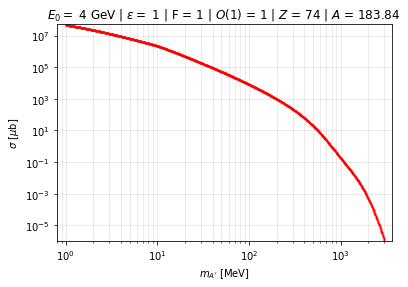

In [7]:
fig, ax = plt.subplots()
plt.figure(1)
plt.plot(MassValue,SigmaValue,'ro',markersize=1)
plt.yscale('log')
plt.xscale('log')
#ax.set_yticks([10**(-4),10**(-3),10**(-2),10**(-1),10**0,10**1,10**2,10**3,10**4,10**5,10**6,10**7])
plt.tick_params(axis='both')

plt.ylim(top=max(SigmaValue)*1.2)
plt.ylim(bottom=min(SigmaValue)*0.8)
plt.xlim(right=max(MassValue)*1.2)
plt.xlim(left=min(MassValue)*0.8)

plt.title('$E_0 =$ '+str(E_0)+' GeV | $\epsilon =$ ' +str(Epsilon)+' | F = '+str(CorrectionFactor)+' | $O(1)$ = '+str(SomethingOfOrder1) +' | $Z$ = '+str(Z) +' | $A$ = '+str(A))
plt.xlabel('$m_{A\'}$ [MeV]')
plt.ylabel('$\sigma$ [$\mu$b] ')
plt.grid(color='grey', linestyle='-', linewidth=0.5,alpha=0.3,which="both")
plt.savefig(OutputDir+'XSecLDMX_E0_'+str(E_0).replace('.','_')+'_Epsilon_'+str(Epsilon).replace('.','_')+'_F_'+str(CorrectionFactor).replace('.','_')+'_O1_'+str(SomethingOfOrder1).replace('.','_')+'_T_'+str(T).replace('.','_')+'_Z_'+str(Z).replace('.','_')+'_A_'+str(A).replace('.','_')+'.pdf', format='pdf')
plt.show()

#### Change cell below from Raw to Code if Plotly is used

#### Doing the plot of the number of Events

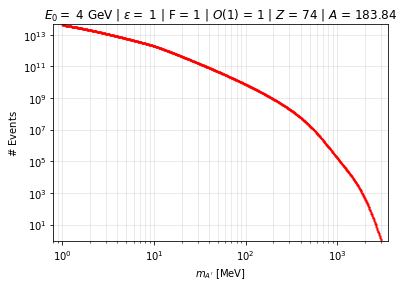

In [8]:
fig, ax = plt.subplots()
plt.figure(1)
plt.plot(MassValue,EventsValue,'ro',markersize=1)
plt.yscale('log')
plt.xscale('log')
#ax.set_yticks([10**(-4),10**(-3),10**(-2),10**(-1),10**0,10**1,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10,10**11,10**12,10**13])
plt.tick_params(axis='both')

plt.ylim(top=max(EventsValue)*1.2)
plt.ylim(bottom=min(EventsValue)*0.8)
plt.xlim(right=max(MassValue)*1.2)
plt.xlim(left=min(MassValue)*0.8)

plt.title('$E_0 =$ '+str(E_0)+' GeV | $\epsilon =$ ' +str(Epsilon)+' | F = '+str(CorrectionFactor)+' | $O(1)$ = '+str(SomethingOfOrder1) +' | $Z$ = '+str(Z) +' | $A$ = '+str(A))
plt.xlabel('$m_{A\'}$ [MeV]')
plt.ylabel('$\#$ Events')
plt.grid(color='grey', linestyle='-', linewidth=0.5,alpha=0.3,which="both")
plt.savefig(OutputDir+'NeEventsLDMX_E0_'+str(E_0).replace('.','_')+'_Epsilon_'+str(Epsilon).replace('.','_')+'_F_'+str(CorrectionFactor).replace('.','_')+'_O1_'+str(SomethingOfOrder1).replace('.','_')+'_T_'+str(T).replace('.','_')+'_Z_'+str(Z).replace('.','_')+'_A_'+str(A).replace('.','_')+'.pdf', format='pdf')
plt.show()

#### Change cell below from Raw to Code if Plotly is used